# **Bioinformatics Project - Part 2 Computational Drug Discovery Exploratory Data Analysis**

In this Notebook I will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit**

Do not run the following code is you are running in the bioinformatics (Python 3.8.20) environment/kernel

In [1]:
# ! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
# ! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
# ! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
# ! conda install -c rdkit rdkit -y
# import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages/')

## **Load bioactivity data**

In [2]:
data_folder = "data"
formatted_target_name = 'Kallikrein_1'

In [3]:
# ! wget https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_03_bioactivity_data_curated.csv

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv(data_folder + '/' + formatted_target_name + '_03_bioactivity_data_curated.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL174750,NS(=O)(=O)c1ccccc1-c1ccc(C(=O)Nc2ccccc2C(=O)Nc...,2100.0,intermediate
1,CHEMBL294121,CN1CCN=C1c1ccc(C(=O)N2CCN(S(=O)(=O)c3cc4cc(Cl)...,5800.0,intermediate
2,CHEMBL432306,N=C(N)c1cccc(OCCNC(=O)c2ccc(-c3ccccc3S(N)(=O)=...,2100.0,intermediate
3,CHEMBL297835,N=C(N)c1cccc(Oc2ccccc2NC(=O)c2ccc(-c3ccccc3S(N...,250.0,active
4,CHEMBL10378,O=c1oc(-c2ccccc2I)nc2ccccc12,9890.0,intermediate
...,...,...,...,...
332,CHEMBL3897372,Cc1cc(C)n(Cc2ccc(Cn3cc(C(=O)NCc4c(C)cc(N)nc4C)...,40000.0,inactive
333,CHEMBL5204354,COc1ccnc(CNC(=O)c2cn(Cc3ccc(Cn4ccccc4=O)cc3)nc...,4000.0,intermediate
334,CHEMBL5095064,COCc1nn(Cc2ccc(Cn3cc(F)ccc3=O)cc2)cc1C(=O)NCc1...,40000.0,inactive
335,CHEMBL5276515,Nc1nn(Cc2ccc(Cn3ccccc3=O)cc2)cc1C(=O)NCCOc1ccc...,2.9,active


In [6]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [7]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [8]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL174750,2100.0,intermediate,NS(=O)(=O)c1ccccc1-c1ccc(C(=O)Nc2ccccc2C(=O)Nc...
1,CHEMBL294121,5800.0,intermediate,CN1CCN=C1c1ccc(C(=O)N2CCN(S(=O)(=O)c3cc4cc(Cl)...
2,CHEMBL432306,2100.0,intermediate,N=C(N)c1cccc(OCCNC(=O)c2ccc(-c3ccccc3S(N)(=O)=...
3,CHEMBL297835,250.0,active,N=C(N)c1cccc(Oc2ccccc2NC(=O)c2ccc(-c3ccccc3S(N...
4,CHEMBL10378,9890.0,intermediate,O=c1oc(-c2ccccc2I)nc2ccccc12
...,...,...,...,...
332,CHEMBL3897372,40000.0,inactive,Cc1cc(C)n(Cc2ccc(Cn3cc(C(=O)NCc4c(C)cc(N)nc4C)...
333,CHEMBL5204354,4000.0,intermediate,COc1ccnc(CNC(=O)c2cn(Cc3ccc(Cn4ccccc4=O)cc3)nc...
334,CHEMBL5095064,40000.0,inactive,COCc1nn(Cc2ccc(Cn3cc(F)ccc3=O)cc2)cc1C(=O)NCc1...
335,CHEMBL5276515,2.9,active,Nc1nn(Cc2ccc(Cn3ccccc3=O)cc2)cc1C(=O)NCCOc1ccc...


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [9]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [10]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [11]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,551.422,4.66310,3.0,5.0
1,485.997,2.66000,1.0,5.0
2,438.509,2.09387,4.0,5.0
3,486.553,4.32967,4.0,5.0
4,349.127,3.45960,0.0,3.0
...,...,...,...,...
332,444.543,2.71208,2.0,8.0
333,515.467,3.63290,1.0,7.0
334,509.513,2.89960,1.0,8.0
335,477.952,3.18580,2.0,7.0


### **Combine DataFrames**

In [12]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL174750,NS(=O)(=O)c1ccccc1-c1ccc(C(=O)Nc2ccccc2C(=O)Nc...,2100.0,intermediate,551.422,4.66310,3.0,5.0
1,CHEMBL294121,CN1CCN=C1c1ccc(C(=O)N2CCN(S(=O)(=O)c3cc4cc(Cl)...,5800.0,intermediate,485.997,2.66000,1.0,5.0
2,CHEMBL432306,N=C(N)c1cccc(OCCNC(=O)c2ccc(-c3ccccc3S(N)(=O)=...,2100.0,intermediate,438.509,2.09387,4.0,5.0
3,CHEMBL297835,N=C(N)c1cccc(Oc2ccccc2NC(=O)c2ccc(-c3ccccc3S(N...,250.0,active,486.553,4.32967,4.0,5.0
4,CHEMBL10378,O=c1oc(-c2ccccc2I)nc2ccccc12,9890.0,intermediate,349.127,3.45960,0.0,3.0
...,...,...,...,...,...,...,...,...
332,CHEMBL3897372,Cc1cc(C)n(Cc2ccc(Cn3cc(C(=O)NCc4c(C)cc(N)nc4C)...,40000.0,inactive,444.543,2.71208,2.0,8.0
333,CHEMBL5204354,COc1ccnc(CNC(=O)c2cn(Cc3ccc(Cn4ccccc4=O)cc3)nc...,4000.0,intermediate,515.467,3.63290,1.0,7.0
334,CHEMBL5095064,COCc1nn(Cc2ccc(Cn3cc(F)ccc3=O)cc2)cc1C(=O)NCc1...,40000.0,inactive,509.513,2.89960,1.0,8.0
335,CHEMBL5276515,Nc1nn(Cc2ccc(Cn3ccccc3=O)cc2)cc1C(=O)NCCOc1ccc...,2.9,active,477.952,3.18580,2.0,7.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [13]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis = 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [14]:
df_combined.standard_value.describe()

count       337.000000
mean      24961.738902
std       70017.632794
min           2.900000
25%        8400.000000
50%       10000.000000
75%       11000.000000
max      630957.340000
Name: standard_value, dtype: float64

In [15]:
-np.log10( (10**-9)* 100000000 )

np.float64(1.0)

In [16]:
-np.log10( (10**-9)* 10000000000 )

np.float64(-1.0)

In [17]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis = 1)
        
    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [18]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL174750,NS(=O)(=O)c1ccccc1-c1ccc(C(=O)Nc2ccccc2C(=O)Nc...,intermediate,551.422,4.66310,3.0,5.0,2100.0
1,CHEMBL294121,CN1CCN=C1c1ccc(C(=O)N2CCN(S(=O)(=O)c3cc4cc(Cl)...,intermediate,485.997,2.66000,1.0,5.0,5800.0
2,CHEMBL432306,N=C(N)c1cccc(OCCNC(=O)c2ccc(-c3ccccc3S(N)(=O)=...,intermediate,438.509,2.09387,4.0,5.0,2100.0
3,CHEMBL297835,N=C(N)c1cccc(Oc2ccccc2NC(=O)c2ccc(-c3ccccc3S(N...,active,486.553,4.32967,4.0,5.0,250.0
4,CHEMBL10378,O=c1oc(-c2ccccc2I)nc2ccccc12,intermediate,349.127,3.45960,0.0,3.0,9890.0
...,...,...,...,...,...,...,...,...
332,CHEMBL3897372,Cc1cc(C)n(Cc2ccc(Cn3cc(C(=O)NCc4c(C)cc(N)nc4C)...,inactive,444.543,2.71208,2.0,8.0,40000.0
333,CHEMBL5204354,COc1ccnc(CNC(=O)c2cn(Cc3ccc(Cn4ccccc4=O)cc3)nc...,intermediate,515.467,3.63290,1.0,7.0,4000.0
334,CHEMBL5095064,COCc1nn(Cc2ccc(Cn3cc(F)ccc3=O)cc2)cc1C(=O)NCc1...,inactive,509.513,2.89960,1.0,8.0,40000.0
335,CHEMBL5276515,Nc1nn(Cc2ccc(Cn3ccccc3=O)cc2)cc1C(=O)NCCOc1ccc...,active,477.952,3.18580,2.0,7.0,2.9


In [19]:
df_norm.standard_value_norm.describe()

count       337.000000
mean      24961.738902
std       70017.632794
min           2.900000
25%        8400.000000
50%       10000.000000
75%       11000.000000
max      630957.340000
Name: standard_value_norm, dtype: float64

In [20]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL174750,NS(=O)(=O)c1ccccc1-c1ccc(C(=O)Nc2ccccc2C(=O)Nc...,intermediate,551.422,4.66310,3.0,5.0,5.677781
1,CHEMBL294121,CN1CCN=C1c1ccc(C(=O)N2CCN(S(=O)(=O)c3cc4cc(Cl)...,intermediate,485.997,2.66000,1.0,5.0,5.236572
2,CHEMBL432306,N=C(N)c1cccc(OCCNC(=O)c2ccc(-c3ccccc3S(N)(=O)=...,intermediate,438.509,2.09387,4.0,5.0,5.677781
3,CHEMBL297835,N=C(N)c1cccc(Oc2ccccc2NC(=O)c2ccc(-c3ccccc3S(N...,active,486.553,4.32967,4.0,5.0,6.602060
4,CHEMBL10378,O=c1oc(-c2ccccc2I)nc2ccccc12,intermediate,349.127,3.45960,0.0,3.0,5.004804
...,...,...,...,...,...,...,...,...
332,CHEMBL3897372,Cc1cc(C)n(Cc2ccc(Cn3cc(C(=O)NCc4c(C)cc(N)nc4C)...,inactive,444.543,2.71208,2.0,8.0,4.397940
333,CHEMBL5204354,COc1ccnc(CNC(=O)c2cn(Cc3ccc(Cn4ccccc4=O)cc3)nc...,intermediate,515.467,3.63290,1.0,7.0,5.397940
334,CHEMBL5095064,COCc1nn(Cc2ccc(Cn3cc(F)ccc3=O)cc2)cc1C(=O)NCc1...,inactive,509.513,2.89960,1.0,8.0,4.397940
335,CHEMBL5276515,Nc1nn(Cc2ccc(Cn3ccccc3=O)cc2)cc1C(=O)NCCOc1ccc...,active,477.952,3.18580,2.0,7.0,8.537602


In [21]:
df_final.pIC50.describe()

count    337.000000
mean       5.027954
std        0.570306
min        3.200000
25%        4.958607
50%        5.000000
75%        5.075721
max        8.537602
Name: pIC50, dtype: float64

Let's write this to CSV file.

In [22]:
df_final.to_csv(data_folder + '/' + formatted_target_name + '_04_bioactivity_data_3class_pIC50.csv')

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [23]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
3,CHEMBL297835,N=C(N)c1cccc(Oc2ccccc2NC(=O)c2ccc(-c3ccccc3S(N...,active,486.553,4.32967,4.0,5.0,6.602060
5,CHEMBL273264,N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,active,347.378,2.64844,5.0,4.0,6.187087
6,CHEMBL21052,Cc1cc(C(=O)Nc2ccc(C3=NCCN3C)cc2F)n(-c2cc3ccccc...,inactive,445.473,4.55642,1.0,5.0,5.000000
7,CHEMBL20918,Cc1cc(C(=O)Nc2ccc(C(=N)N(C)C)cc2F)n(-c2ccc3cc(...,inactive,449.917,5.26569,2.0,4.0,5.000000
8,CHEMBL279486,CN(C)C(=N)c1ccc(NC(=O)c2cc(C(F)(F)F)nn2-c2cc3c...,inactive,487.432,5.46177,2.0,4.0,5.000000
...,...,...,...,...,...,...,...,...
331,CHEMBL3617968,CC(=O)C1=C(C)N(c2cccc(C(F)(F)F)c2)C(=O)N[C@@H]...,inactive,400.360,4.10598,1.0,4.0,4.522879
332,CHEMBL3897372,Cc1cc(C)n(Cc2ccc(Cn3cc(C(=O)NCc4c(C)cc(N)nc4C)...,inactive,444.543,2.71208,2.0,8.0,4.397940
334,CHEMBL5095064,COCc1nn(Cc2ccc(Cn3cc(F)ccc3=O)cc2)cc1C(=O)NCc1...,inactive,509.513,2.89960,1.0,8.0,4.397940
335,CHEMBL5276515,Nc1nn(Cc2ccc(Cn3ccccc3=O)cc2)cc1C(=O)NCCOc1ccc...,active,477.952,3.18580,2.0,7.0,8.537602


Let's write this to CSV file.

In [24]:
df_2class.to_csv(data_folder + '/' + formatted_target_name + '_05_bioactivity_data_2class_pIC50.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [25]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

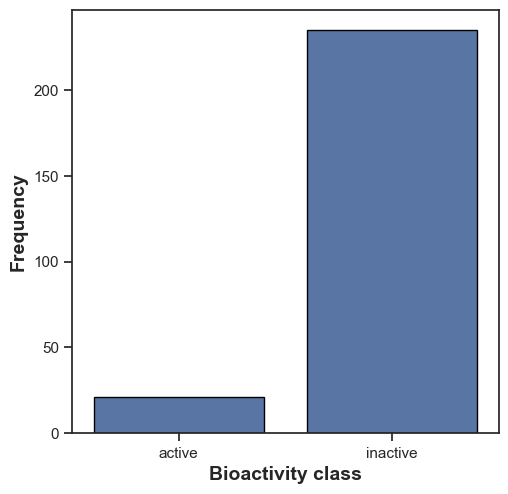

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plots/frequency_plot_bioactivity_class.png')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

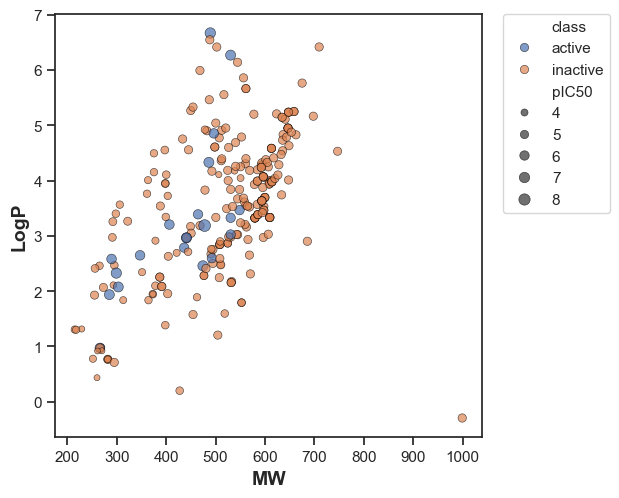

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plots/scatter_plot_MW_vs_LogP.png')

### **Box plots**

#### **pIC50 value**

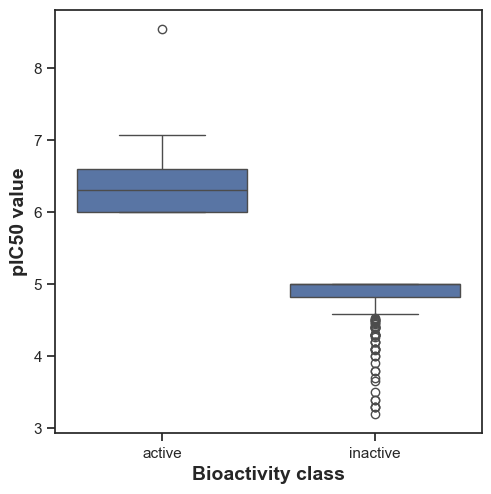

In [28]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plots/box_plot_pIC50.png')

**Statistical analysis | Mann-Whitney U Test**

In [29]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'data/mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [30]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,4935.0,2.021284e-17,0.05,Different distribution (reject H0)


#### **MW**

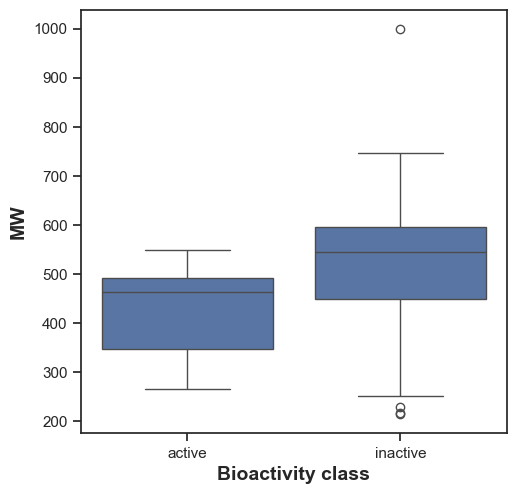

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plots/box_plot_MW.png')

In [32]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1268.5,0.000227,0.05,Different distribution (reject H0)


#### **LogP**

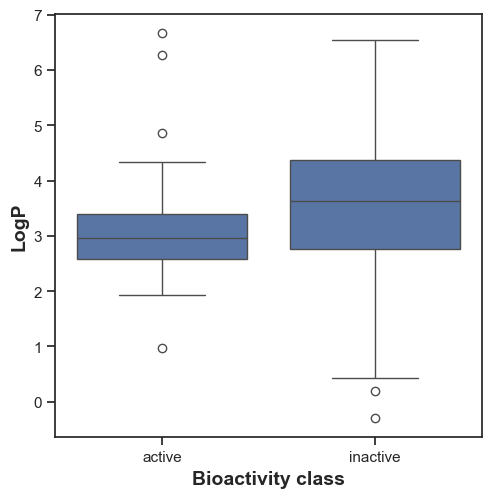

In [33]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plots/box_plot_LogP.png')

**Statistical analysis | Mann-Whitney U Test**

In [34]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1893.0,0.077453,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

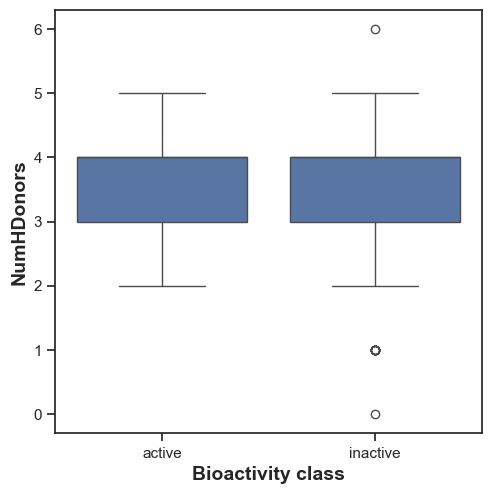

In [35]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plots/box_plot_NumHDonors.png')

**Statistical analysis | Mann-Whitney U Test**

In [36]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2251.0,0.466117,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

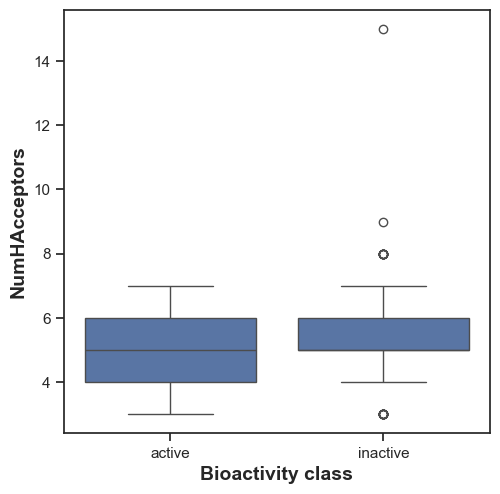

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plots/box_plot_NumHAcceptors.png')

In [38]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1763.0,0.024783,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## **Zip files**

In [39]:
# ! zip -r results.zip . -i *.csv *.pdf